# Header

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dog-breed-identification/"
sz=224
arch=resnet34
bs=28

In [5]:
n = len(open(f'{PATH}labels.csv').readlines()) - 1
val_idxs = get_cv_idxs(n)

# Initial Exploration

In [6]:
ls {PATH}

labels.csv  models/  sample_submission.csv  subm/  test/  tmp/  train/


In [7]:
labels = pd.read_csv(f'{PATH}/labels.csv')
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,5d61d75204f9ace78b40fc444ce6bfeb,scottish_deerhound
freq,1,126


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24a2b92dd8>]], dtype=object)

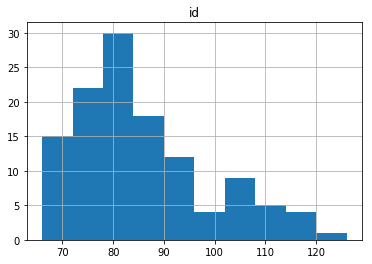

In [8]:
pt = labels.pivot_table(index='breed', aggfunc=len)
pt.sort_values('id', ascending=False).hist()

In [9]:
files = os.listdir(f'{PATH}train')
imsizes = [Image.open(f'{PATH}train/{fp}').size for fp in files]
imheight, imwidth = zip(*imsizes)

(array([3798., 6259.,  108.,   18.,   11.,    4.,   19.,    2.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

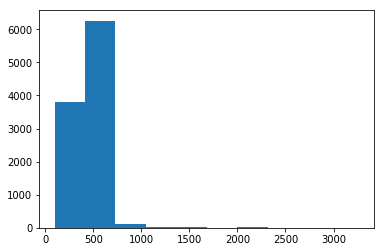

In [10]:
plt.hist(imheight)

(array([3595., 6395.,  150.,   28.,   18.,   20.,   10.,    3.,    0.,    3.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

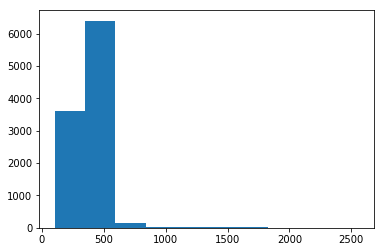

In [11]:
plt.hist(imwidth)

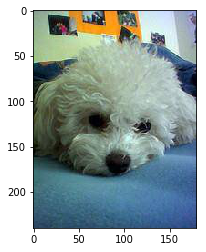

In [12]:
plt.imshow(plt.imread(f'{PATH}train/{files[0]}'))

# Model Fine Tuning

In [13]:
tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                    test_name='test', val_idxs=val_idxs,
                                    tfms=tfms, bs=bs, suffix='.jpg')

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

 80%|███████▉  | 234/293 [00:02<00:00, 91.45it/s, loss=15.5] 


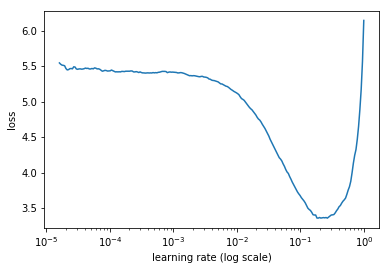

In [15]:
learn.lr_find()
learn.sched.plot()

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [17]:
learn.precompute = True
learn.fit(1e-1, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      1.43731    0.907213   0.742172  



[array([0.90721]), 0.7421722118168661]

In [18]:
learn.precompute = False
learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      1.084094   0.551301   0.831703  
    1      0.969815   0.540351   0.824364                    



[array([0.54035]), 0.8243639934552859]

In [19]:
learn.precompute = False
learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.855234   0.529819   0.830235  
    1      0.956343   0.58646    0.817515                    
    2      0.705825   0.511169   0.834638                    
    3      1.141355   0.629049   0.808708                    
    4      0.92902    0.602267   0.821429                    
    5      0.659387   0.52514    0.838552                    
    6      0.632091   0.508524   0.839041                    



[array([0.50852]), 0.8390410991564189]

In [20]:
learn.precompute = False
learn.save(f'dogbreeds_{arch}')

In [21]:
learn.precompute = False
learn.load(f'dogbreeds_{arch}')

# Model Analysis

In [22]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [23]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.8556751467710372, 0.45855393294407587)

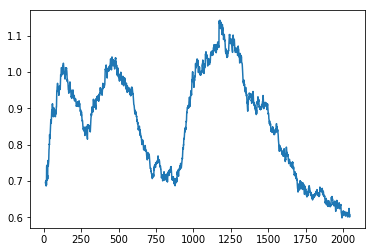

In [24]:
learn.sched.plot_loss()

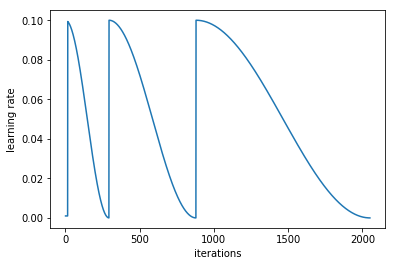

In [25]:
learn.sched.plot_lr()

# Submission

In [26]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [27]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [28]:
ds.insert(0, 'id', [fname[5:-4] for fname in data.test_ds.fnames])

In [29]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [30]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/courses/dl1/data/dog-breed-identification/subm/subm.gz

# Individual Prediction

In [31]:
fn = data.val_ds.fnames[0]

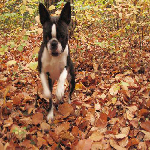

In [32]:
Image.open(f'{PATH}{fn}').resize((150, 150))

In [33]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [34]:
im = val_tfms(plt.imread(f'{PATH}{fn}'))
preds = learn.predict_array(im[None])
np.argmax(preds)

31